# From k value to Gardner via HYPAGS

*Martin Vonk - 2025*

## Setup

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pedon as pe

pe.show_versions()

python     : 3.11.14
pedon      : 0.0.11
numpy      : 2.4.1
matplotlib : 3.10.8
pandas     : 2.3.3
scipy      : 1.17.0


### Helper plot

In [2]:
def plot_compare(
    soilsample: pe.SoilSample, soilmodel: pe.soilmodel.SoilModel
) -> np.typing.NDArray[plt.Axes]:
    f, ax = plt.subplots(1, 2, sharey=True, figsize=(7.0, 6.0))
    ax[0].scatter(soilsample.theta, soilsample.h, c="k", s=10, label="Soil Sample")
    _ = pe.soilmodel.plot_swrc(
        soilmodel, ax=ax[0], label=f"Soil Model {soilmodel.__class__.__name__}"
    )
    ax[0].set_yscale("log")
    ax[0].set_xlim(0, 0.5)
    ax[0].set_yticks(soilsample.h)
    ax[0].set_xticks(np.linspace(0, 0.5, 6))
    ax[0].set_ylim(min(soilsample.h), max(soilsample.h))
    ax[1].scatter(soilsample.k, soilsample.h, c="k", s=10)
    _ = pe.soilmodel.plot_hcf(soilmodel, ax=ax[1])

    ax[1].set_yscale("log")
    ax[1].set_xscale("log")

    k_left = 10 ** (np.floor(np.log10(min(soilsample.k))) - 1)
    k_right = 10 ** (np.ceil(np.log10(max(soilsample.k))) + 1)
    ax[1].set_xlim(k_left, k_right)
    ax[0].set_ylabel(r"|$\psi$| [cm]")
    ax[0].set_xlabel(r"$\theta$ [-]")
    ax[1].set_xlabel(r"$K_s$ [cm/d]")
    ncol = 3
    ax[0].legend(
        loc=(-0.02, 1),
        fontsize=6,
        frameon=False,
        ncol=ncol,
        columnspacing=0.8,
        handlelength=2.5,
    )

    f.align_xlabels()
    return ax

## Estimate Genuchten parameters via HYPAGS

In [3]:
k_cmd = 100.0  # cm/d
k_ms = k_cmd / 86400 / 100  # m/s since HYPAGS expects that
genuchten = pe.SoilSample(k=np.array([k_ms])).hypags()
genuchten.k_s = k_cmd  # convert back to cm/d
genuchten

Genuchten(k_s=100.0, theta_r=0.108, theta_s=np.float64(0.260064701261806), alpha=np.float64(3.2905002387762474), n=np.float64(1.7228201552429758), l=0.5)

## Estimate Gardner model from Genuchten curve

### Sample Genuchten curve for data points

In [4]:
h = np.logspace(
    -3, 2, 100
)  # carefull with sampling h since k goes to zero very fast for large h which gives trouble with logs
k = genuchten.k(h)
theta = genuchten.theta(h)
soilsample = pe.SoilSample(h=h, k=k, theta=theta)

### Set initial parameters and bounds

In [5]:
pbounds = pe.get_params("Gardner")
pbounds.loc["k_s"] = [k_cmd, k_cmd - 100.0, k_cmd + 10.0]
pbounds.loc["theta_s"] = [genuchten.theta_s, 0.2, 0.3]
pbounds.loc["c"] = [0.15, 0.0001, 0.5]
pbounds.loc["m"] = [0.3, 0.0001, 0.5]
pbounds

,p_ini,p_min,p_max
k_s,100.000000,0.0000,110.0
theta_s,0.260065,0.2000,0.3
m,0.300000,0.0001,0.5
c,0.150000,0.0001,0.5


#### Show fit for initial bounds

(np.float64(0.001), np.float64(100.0))

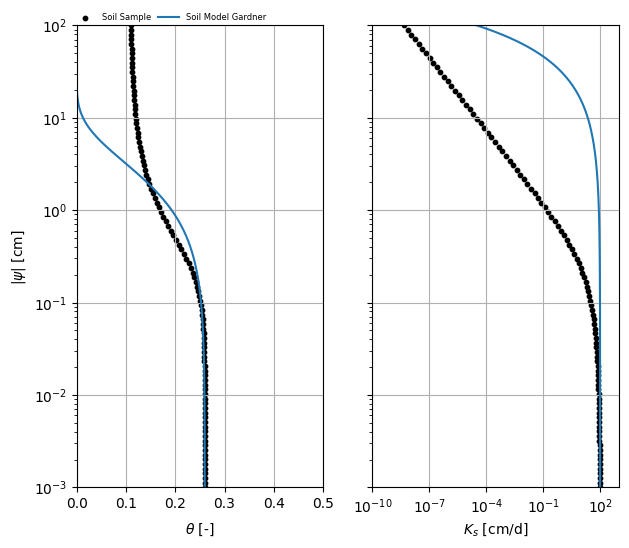

In [6]:
# compare initial guesses with genuchten
gardner_ini = pe.Gardner(**pbounds["p_ini"].to_dict())
axes = plot_compare(soilsample, gardner_ini)
axes[0].set_ylim(h[0], h[-1])

### Fit

In [7]:
gardner = soilsample.fit(
    pe.Gardner,
    pbounds=pbounds,
    # k_s=k_cmd,  # fix option to fix k_s and only fit k_r
    W1=0.1,  # how to weight k vs theta data
)
gardner

Gardner(k_s=np.float64(1.7140071030290098), theta_s=np.float64(0.22527115097409922), m=np.float64(0.025716662197584478), c=np.float64(0.30552460435612094))

(np.float64(0.001), np.float64(100.0))

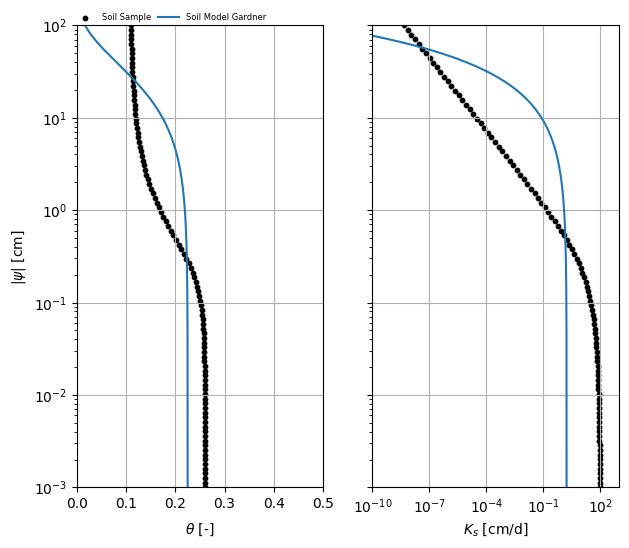

In [8]:
# compare initial guesses with genuchten
axes = plot_compare(soilsample, gardner)
axes[0].set_ylim(h[0], h[-1])